# Model Construction

## Start here

Always run this cell first, as the ```base_folder``` variable is used everywhere in this notebook.

In [1]:
import pandas as pd

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.set_option('max_colwidth',20)

#change this to match your own Regional Performance Forecasting folder
base_folder = 'C:/Users/Tfarhy/OneDrive - Network Rail/Regional Performance Forecasting/'
assert os.path.isdir(base_folder), 'Base folder does not exist'

#data-main comes from https://github.com/C-CA/data. It should be already included in the Regional Performance Forecasting zip.
nr_data_folder = base_folder + 'data-main/'

## I. Data pivots

### Excel or CSV data read (helper function)

This just reads all Excel sheets inside a folder that have sheet name ```sheet_name```.

In [2]:
import glob, os

path = base_folder + 'on-time-gbtt-route'
sheet_name = 'Data'

all_files = glob.iglob(os.path.join(path, "*.xlsx")) 
dfs = []
for f in all_files:
    print(f'reading {f}')
    if sheet_name:
        df_from_each_file = pd.read_excel(f, engine='openpyxl', sheet_name = sheet_name)
    else:
        df_from_each_file = pd.read_excel(f, engine='openpyxl')
    dfs.append(df_from_each_file)
    
concatenated_df   = pd.concat(dfs, ignore_index=True)
    # doesn't create a list, nor does it append to one

reading C:/Users/Tfarhy/OneDrive - Network Rail/Regional Performance Forecasting/on-time-gbtt-route\Offset -14 to -19 Route.xlsx
reading C:/Users/Tfarhy/OneDrive - Network Rail/Regional Performance Forecasting/on-time-gbtt-route\Offset -20 to -26 Route.xlsx
reading C:/Users/Tfarhy/OneDrive - Network Rail/Regional Performance Forecasting/on-time-gbtt-route\Offset -7 to -13 Route.xlsx


In [2]:
import pandas as pd
import numpy as np
totaldelay =       pd.read_pickle(base_folder + 'pickles/total-delay.pkl')
ppmbyday =         pd.read_pickle(base_folder + 'pickles/ppm-by-day.pkl')
ontimebylocation = pd.read_pickle(base_folder + 'pickles/on-time-by-location.pkl')
gbttoperator =     pd.read_pickle(base_folder + 'pickles/gbtt-operator.pkl')
gbttroute =        pd.read_pickle(base_folder + 'pickles/gbtt-route.pkl')

### 1. Delay (by route)

In [3]:
delay_mins_by_route = totaldelay.pivot_table(index = 'Date', aggfunc = 'sum', columns = 'Route Name', values = 'PfPI Minutes')
delay_mins_by_route['West Coast South'] = delay_mins_by_route['West Coast South'].fillna(delay_mins_by_route['West Coast Mainline South'])
delay_mins_by_route = delay_mins_by_route.drop('West Coast Mainline South', axis=1).fillna(0)

### 2. Planned train count (by op) and tiploc (by route)

In [4]:
planned_trains_by_operator = ppmbyday.pivot_table(index = 'Date', aggfunc = sum, columns = 'Operator Name', values = 'Planned')
planned_trains_by_operator['TfW Rail Services'] = planned_trains_by_operator['TfW Rail Services'].fillna(planned_trains_by_operator['TfW Rail Limited'])
planned_trains_by_operator = planned_trains_by_operator.drop('TfW Rail Limited', axis=1).fillna(0)
planned_trains_by_operator = planned_trains_by_operator.drop(['Locomotive Services',],axis=1)

tiplocs_by_route = ontimebylocation.pivot_table(index = 'Date', aggfunc = sum, columns = 'Route Description', values = 'Count of Trains/Timing Points - WTT')
tiplocs_by_route['West Coast South'] = tiplocs_by_route['West Coast South'].fillna(tiplocs_by_route['West Coast Mainline South'])
tiplocs_by_route = tiplocs_by_route.drop('West Coast Mainline South', axis=1).fillna(0)
tiplocs_by_route = tiplocs_by_route.drop(['Core Valley Lines', 'Private Railway', 'TfW Cardiff Valleys', 'The Chiltern Railway Co Ltd', 'High Speed'],axis=1)


### 3. RDIS (by route)

It is unknown how to check if RDIS's passenger counts are actually low on a certain day, or just incomplete.

In [5]:
stip = pd.read_excel(nr_data_folder + 'mapping/stanox-tiploc.xlsx')
stroute = pd.read_excel(nr_data_folder + 'mapping/stanox-to-route.xlsx')
tiproute = stroute[['Route Description','Geography Code']].merge(stip[['STANOX', 'TIPLOC']], 
    left_on = 'Geography Code', right_on = 'STANOX', how = 'inner').drop_duplicates(subset = ['TIPLOC'])

passcount0 = pd.read_pickle(base_folder + 'pickles/passcounts.pkl')
passcount0['runDate'] = pd.to_datetime(passcount0['runDate'])

#Look up the origin TIPLOC's Route for each train.
passcount = passcount0.merge(tiproute[['TIPLOC','Route Description']], 
                            left_on = 'origin', right_on ='TIPLOC')

#Drop TIPLOCS that didn't have a route name.
passcount = passcount.dropna(subset=['Route Description'])

passcount_by_route = passcount.pivot_table(index='runDate', aggfunc=sum, columns= 'Route Description', values = 'avgPassengerCount')

#Drop Chiltern because it has NAs almost everywhere. Drop TfW Cardiff because it has NA on New Year's Day, 
#and it's a non-NR operator anyway.
passcount_by_route = passcount_by_route.drop(['The Chiltern Railway Co Ltd', 'TfW Cardiff Valleys'], axis=1)
passcount_by_route = passcount_by_route.drop(pd.to_datetime('2020-06-01'))
#Drop days that had NaN avgPassengerCount. In 2020, Christmas and Boxing Day.
passcount_by_route = passcount_by_route.dropna(axis=0)

#Rename to match other DataFrames.
passcount_by_route = passcount_by_route.rename(columns={'West Coast Mainline South':'West Coast South'})

assert not passcount_by_route.isna().any(axis=1).any()

#### 3a. More RDIS training data by scaling Footfall

In [6]:
from sklearn.metrics import r2_score

footfall = pd.read_csv(base_folder + 'ppm-on-time-new-data.csv')[['Date','Footfall']]
footfall['Date'] = pd.to_datetime(footfall['Date'], format='%d/%m/%Y')
footfall = footfall.set_index('Date')

pmf = pd.read_excel(base_folder + 'pmf2021.xlsx', parse_dates=False)
pmf = pmf.pivot_table(index = 'Day', aggfunc = 'sum', values = 'Count In')

footfall = footfall.join(pmf, how='outer')
footfall = pd.DataFrame(footfall['Footfall'].fillna(footfall['Count In']))

sf = passcount_by_route.join(footfall, how='inner')[passcount_by_route.columns].apply(lambda row:row/footfall['Footfall'].loc[row.index])
sf = sf.mean()
naively_scaled = pd.DataFrame(footfall.values*sf.values, index = footfall.index, columns=passcount_by_route.columns)


idx  =passcount_by_route.index.intersection(naively_scaled.index)
actual = passcount_by_route.loc[idx]
pred = naively_scaled.loc[idx]

r2_score(actual, pred, multioutput='raw_values')

overlapping_index = naively_scaled.index.intersection(passcount_by_route.index)
naively_scaled.drop(overlapping_index)
filled = pd.concat([naively_scaled.drop(overlapping_index), passcount_by_route]).sort_index()
assert not filled.isna().any(axis=None)

passcount_by_route_filled = filled.drop('Private Railway',axis=1)
passcount_by_route_filled = passcount_by_route_filled.drop(['High Speed'], axis=1)

### 4. On Time (by op) and PPM (by op)

In [7]:
#otbo
countoftrains = ppmbyday.pivot_table(index = 'Date', aggfunc = sum, columns = 'Operator Name', values = 'Count of Trains/Timing Points - WTT')
ontimetrains = ppmbyday.pivot_table(index = 'Date', aggfunc = sum, columns = 'Operator Name', values = 'On Time - WTT')

countoftrains['TfW Rail Services'] = countoftrains['TfW Rail Services'].fillna(countoftrains['TfW Rail Limited'])
countoftrains = countoftrains.drop('TfW Rail Limited', axis=1).fillna(0)
countoftrains = countoftrains.drop(['Locomotive Services'],axis=1)

ontimetrains['TfW Rail Services'] = ontimetrains['TfW Rail Services'].fillna(ontimetrains['TfW Rail Limited'])
ontimetrains = ontimetrains.drop('TfW Rail Limited', axis=1).fillna(0)
ontimetrains = ontimetrains.drop(['Locomotive Services'],axis=1)

on_time_by_operator = (ontimetrains/countoftrains)
national_on_time = pd.DataFrame(ontimetrains.fillna(0).sum(axis=1)/countoftrains.fillna(0).sum(axis=1), columns = ['National'])

######otbr
countoftrains = ontimebylocation.pivot_table(index = 'Date', aggfunc = sum, columns = 'Route Description', values = 'Count of Trains/Timing Points - WTT')
ontimetrains = ontimebylocation.pivot_table(index = 'Date', aggfunc = sum, columns = 'Route Description', values = 'On Time - WTT')

countoftrains = countoftrains.drop(['Core Valley Lines', 'Private Railway', 'TfW Cardiff Valleys', 'The Chiltern Railway Co Ltd', 'High Speed'],axis=1)
ontimetrains = ontimetrains.drop(['Core Valley Lines', 'Private Railway', 'TfW Cardiff Valleys', 'The Chiltern Railway Co Ltd', 'High Speed'],axis=1)

on_time_by_route = (ontimetrains/countoftrains)
on_time_by_route['West Coast South'] = on_time_by_route['West Coast South'].fillna(on_time_by_route['West Coast Mainline South'])
on_time_by_route = on_time_by_route.drop('West Coast Mainline South', axis=1)

###ppbo
plannedtrains = ppmbyday.pivot_table(index = 'Date', aggfunc = sum, columns = 'Operator Name', values = 'Planned')
ppmtrains = ppmbyday.pivot_table(index = 'Date', aggfunc = sum, columns = 'Operator Name', values = 'PPM')

ppm_by_operator = (ppmtrains/plannedtrains)
ppm_by_operator['TfW Rail Services'] = ppm_by_operator['TfW Rail Services'].fillna(ppm_by_operator['TfW Rail Limited'])
ppm_by_operator = ppm_by_operator.drop('TfW Rail Limited', axis=1).fillna(0)
ppm_by_operator = ppm_by_operator.drop(['Locomotive Services',],axis=1)

#### 4a. On Time GBTT (by op and by route)

In [8]:
toclookup = pd.read_csv(base_folder + 'operator-lookup.csv')
gbttoperator_with_name = gbttoperator.merge(toclookup, left_on='Operator', right_on='Business Code', how='inner')
assert not gbttoperator_with_name['Operator Name'].isna().any()

planned_op = gbttoperator_with_name.pivot_table(index = 'Date', aggfunc = sum, columns = 'Operator Name', values = 'Count of Trains/Timing Points')
ontime_op =  gbttoperator_with_name.pivot_table(index = 'Date', aggfunc = sum, columns = 'Operator Name', values = 'v_On Time')
on_time_by_operator_gbtt = ontime_op/planned_op

national_on_time_gbtt = pd.DataFrame(ontime_op.fillna(0).sum(axis=1)/ planned_op.fillna(0).sum(axis=1), columns = ['National'])

planned_rt = gbttroute.pivot_table(index = 'Date', aggfunc = sum, columns = 'Route Description', values = 'Count of Trains/Timing Points')
ontime_rt =  gbttroute.pivot_table(index = 'Date', aggfunc = sum, columns = 'Route Description', values = 'v_On Time')
on_time_by_route_gbtt = ontime_rt/planned_rt
on_time_by_route_gbtt = on_time_by_route_gbtt.drop(['Private Railway', 'TfW Cardiff Valleys', 'The Chiltern Railway Co Ltd', 'High Speed'],axis=1)


### 5. Ensure Route and Operator names are consistent among all DataFrames

In [9]:
assert  (delay_mins_by_route.columns == passcount_by_route_filled.columns).all() and \
        (delay_mins_by_route.columns == on_time_by_route.columns).all() and \
        (delay_mins_by_route.columns == tiplocs_by_route.columns).all() and \
        (delay_mins_by_route.columns == on_time_by_route_gbtt.columns).all()

assert (planned_trains_by_operator.columns == on_time_by_operator.columns).all() and \
       (planned_trains_by_operator.columns == ppm_by_operator.columns).all() and \
       (planned_trains_by_operator.columns == on_time_by_operator_gbtt.columns).all()

### 6. Save pivoted data to pickles

In [15]:
for df_name in ['delay_mins_by_route',
                'planned_trains_by_operator','tiplocs_by_route',
                'passcount_by_route_filled', 
                
                'on_time_by_operator', 'on_time_by_route', 
                'ppm_by_operator',
                'on_time_by_operator_gbtt', 'on_time_by_route_gbtt',
                'national_on_time','national_on_time_gbtt']:
    
    globals()[df_name].to_pickle(base_folder + '{}.pkl'.format(df_name), protocol = 4)

## II. Models

### Load pivoted data from pickles

In [2]:
import pandas as pd
import numpy as np

for df_name in ['delay_mins_by_route',
                'planned_trains_by_operator','tiplocs_by_route',
                'passcount_by_route_filled', 
                
                'on_time_by_operator', 'on_time_by_route', 
                'ppm_by_operator',
                'on_time_by_operator_gbtt', 'on_time_by_route_gbtt',
                'national_on_time', 'national_on_time_gbtt']:
    
    df = pd.read_pickle(base_folder +'{}.pkl'.format(df_name))
    exec(f'{df_name} = df')

### Make empty dict of populators

In [5]:
populator_dict = {
                  'delay_mins_populator' : None,
                  'passcount_populator'  : None,
                  'planned_populator'    : None,
                  'tiploc_populator'     : None,
                  'all_feature_names'    : None,
                  'tiploc_names'         : None, 
                 }

### Feature populator 1: Delay mins & count (by Route), generated from Day Name and Severity

In [6]:
#total daily delay
tdd = delay_mins_by_route.sum(axis=1)

#one hundred percent delay
ohp_d = tdd[tdd<tdd.quantile(0.99)].max()

#make a dataframe with cols containing day of the week & severity, and make its index Date to make sure
#any joins we make later are correct
features = pd.DataFrame()
features['day_name'] = delay_mins_by_route.reset_index()['Date'].apply(lambda row:row.day_name())
features['severity'] = (tdd/ohp_d).values
features.index = delay_mins_by_route.index

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline

from sklearn.metrics import r2_score

from sklearn.base import clone

#prepare features and turn day_name from a string to a Category, and make our categorical mask
X = features.copy()
X['day_name'] = X['day_name'].astype('category')
categorical_mask = list(X.dtypes == 'category')

#native categorical encoder
hgbr = HistGradientBoostingRegressor()
nce = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan),
     make_column_selector(dtype_include='category')),
     remainder='passthrough')

delay_populator = make_pipeline(
    nce,
    MultiOutputRegressor(HistGradientBoostingRegressor(random_state=42,
                                                       categorical_features=categorical_mask)))

# joined = X.join(delay_count_by_route)
# X = joined[X.columns]
# y = joined[delay_count_by_route.columns]
# delay_count_populator = clone(delay_populator)
# delay_count_populator.fit(X,y)
# populator_dict['delay_count_populator'] = delay_count_populator

# print('delay count populator scores:',
#       r2_score(delay_count_by_route, delay_count_populator.predict(X), multioutput='raw_values'))

joined = X.join(delay_mins_by_route)
X = joined[X.columns]
y = joined[delay_mins_by_route.columns]
delay_mins_populator =  clone(delay_populator)
delay_mins_populator.fit(X,y)
populator_dict['delay_mins_populator'] = delay_mins_populator

#cross-val not really necessary for a feature populator, so a simple r2 score as a sanity test
print('delay min populator scores:',
      r2_score(delay_mins_by_route, delay_mins_populator.predict(X), multioutput='raw_values'))

delay min populator scores: [0.72626205 0.66820992 0.61774562 0.53207555 0.62078419 0.69671585
 0.77428246 0.61947454 0.61669003 0.56797896 0.64720973 0.49544525
 0.68008455]


#### sanity test : t-sne

How well defined is each weekday's Delay-Per-Operator, so that the feature populator can estimate Delay-Per-Operator based on weekday and severity alone?

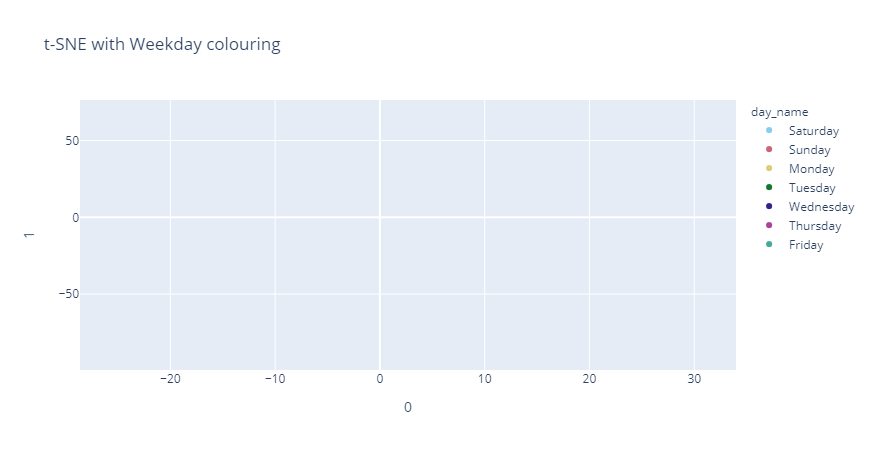

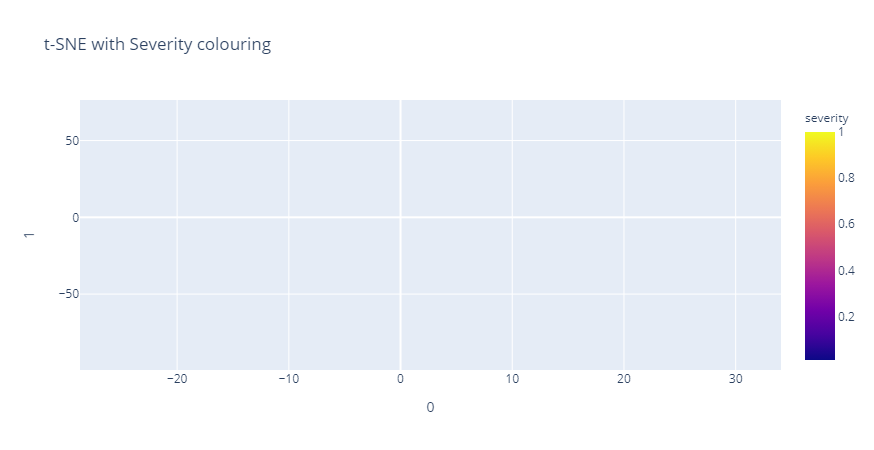

In [120]:
from sklearn.manifold import TSNE
import plotly.express as px

df = delay_mins_by_route.copy()
df['Total'] = df.sum(axis=1)
df = df[df['Total']<df['Total'].quantile(0.99)]
df = df.drop('Total', axis=1)

tsne = TSNE(n_components=2, random_state = 11)
projections = tsne.fit_transform(df.values)

merged = pd.DataFrame(projections, index = df.index).merge(df, left_index = True, right_index = True)
merged = merged.merge(features, left_index=True, right_index = True)

#merged  =merged[merged['Total']<merged['Total'].quantile(0.99)]
fig = px.scatter(
    merged, x=0, y=1,
    color='day_name', hover_data= [merged.index, 'day_name'],
    color_discrete_sequence  = px.colors.qualitative.Safe,
    title='t-SNE with Weekday colouring'
)
fig.show()

fig2 = px.scatter(
    merged, x=0, y=1,
    color='severity', hover_data= [merged.index, 'day_name'],
    color_discrete_sequence  = px.colors.qualitative.Safe,
    title='t-SNE with Severity colouring'
)
fig2.show()

### Feature populator 2: Passcount by route from Day and Total Passcount.

In [7]:
features = pd.DataFrame()
features['day_name'] = passcount_by_route_filled.reset_index()['index'].apply(lambda row:row.day_name())
features['total_passcount'] = passcount_by_route_filled.sum(axis=1).values
features.index = passcount_by_route_filled.index

#drop outliers
features = features[features['total_passcount']>features['total_passcount'].quantile(0.001)]

X = features.copy()
X['day_name'] = X['day_name'].astype('category')
categorical_mask = list(X.dtypes == 'category')

populator = make_pipeline(
    nce,
    MultiOutputRegressor(HistGradientBoostingRegressor(random_state=42,
                                                       categorical_features=categorical_mask)))

joined = X.join(passcount_by_route_filled)
X = joined[X.columns]
y = joined[passcount_by_route_filled.columns]

passcount_populator = clone(populator)
passcount_populator.fit(X,y)
populator_dict['passcount_populator'] = passcount_populator


print('passcount populator scores:',
      r2_score(y, passcount_populator.predict(X), multioutput='raw_values'))

passcount populator scores: [0.99925065 0.99796627 0.99787233 0.99714057 0.99803754 0.99890762
 0.99701495 0.99758605 0.99927244 0.99503562 0.99907001 0.99576753
 0.99865427]


### Feature populator 3: Planned by Operator, generated from Day Name and Total Planned

In [8]:
features = pd.DataFrame()

#generate day names & total planned, making sure index is date
features['day_name'] = planned_trains_by_operator.reset_index()['Date'].apply(lambda row:row.day_name())
features['total_planned'] = planned_trains_by_operator.sum(axis=1).values
features.index = (planned_trains_by_operator.index)

#drop outliers because some days are incomplete (just 50 planned trains)
features = features[features['total_planned']>features['total_planned'].quantile(0.001)]

X = features.copy()
X['day_name'] = X['day_name'].astype('category')
categorical_mask = list(X.dtypes == 'category')

populator = make_pipeline(
    nce,
    MultiOutputRegressor(HistGradientBoostingRegressor(random_state=42,
                                                       categorical_features=categorical_mask)))

joined = X.join(planned_trains_by_operator)
X = joined[X.columns]
y = joined[planned_trains_by_operator.columns]
planned_populator = clone(populator)
planned_populator.fit(X,y)
populator_dict['planned_populator'] = planned_populator

print('planned populator scores:',
      r2_score(y, planned_populator.predict(X), multioutput='raw_values'))

planned populator scores: [0.8984816  0.88943273 0.94295167 0.86988532 0.97122508 0.96458216
 0.9784571  0.82427555 0.9296992  0.70304907 0.83879532 0.87624176
 0.85522099 0.86818044 0.92581988 0.96080107 0.85978398 0.94948386
 0.86135379 0.75881994 0.95126689 0.97260835 0.9135888 ]


### Feature populator 4: TIPLOCs by Route, generated from Planned by Operator

In [9]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

features = planned_trains_by_operator.copy()
features['total_planned'] = planned_trains_by_operator.sum(axis=1).values

#drop outliers because some days are incomplete (just 50 planned trains)
features = features[features['total_planned']>features['total_planned'].quantile(0.001)]
features = features.drop('total_planned', axis=1)

X = features.copy()

# train test split for a quick out-of-sample r2
X_train, X_test = train_test_split(X ,test_size=0.3)

joined = X_train.join(tiplocs_by_route)
X = joined[X.columns]
y = joined[tiplocs_by_route.columns]

tiploc_populator = MultiOutputRegressor(GradientBoostingRegressor())
tiploc_populator.fit(X,y)

joined = X_test.join(tiplocs_by_route)
X = joined[X.columns]
y = joined[tiplocs_by_route.columns]

print('tiploc populator scores:', 
      r2_score(y, tiploc_populator.predict(X_test), multioutput='raw_values'))

#actual train
joined = features.join(tiplocs_by_route)
X = joined[X.columns]
y = joined[tiplocs_by_route.columns]

tiploc_populator.fit(X,y)
populator_dict['tiploc_populator'] = tiploc_populator

tiploc populator scores: [0.9675982  0.98465275 0.95274333 0.95961093 0.98052345 0.96868517
 0.97859894 0.97049914 0.96592324 0.94661824 0.96458612 0.93705974
 0.96984874]


### Final model

In [18]:
all_scores = {}
on_time_by_operator = national_on_time.join(on_time_by_operator)
on_time_by_operator_gbtt = national_on_time_gbtt.join(on_time_by_operator_gbtt)

In [ ]:
from IPython.display import display
pd.set_option('max_colwidth',10)
np.set_printoptions(suppress=True)

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedKFold, train_test_split
from sklearn.preprocessing import StandardScaler

import pickle

#order = dmbr, pcbr, ptbo
features = delay_mins_by_route.add_prefix('Delay minutes: ')\
.join(passcount_by_route_filled.add_prefix('Passenger count: '), how='inner')\
.join(planned_trains_by_operator.add_prefix('Planned trains: '), how='inner')

#we do a train-test split so that we can generate a 'cheap' out-of-sample R2 score when we dont' want to do a 
#full cross-validation (this score is the value printed out when fitting.) 
#We still, however, train the exported model on the full dataset.
features_train, features_test = train_test_split(features, test_size=0.3)
populator_dict['all_feature_names'] = features.columns
populator_dict['tiploc_names'] = tiplocs_by_route.columns

#30-fold cross validation
cv = RepeatedKFold(n_splits=10, n_repeats=3)

#uncomment these lines (and the ones inside a function that say 'uncomment these to do a gridsearch')
#to do a gridsearch
'''
param_grid = {
    'max_depth': [2,4,10,20],
     'min_samples_leaf': [2,4,10,20],
    'min_samples_split': [4,8,15],
     'n_estimators': [20,100,500]
}
'''

def train(output_variable, run_description = None):
    model_dict = {}
    
    if not run_description:
        run_description = str(datetime.datetime.now())

    scores = pd.DataFrame()
    
    #note: the 'operator' isn't always operator, sometimes it may be Route
    for operator in output_variable.columns:
        
        #these numbers came from a GridSearch
        model = GradientBoostingRegressor(**{
                 'max_depth': 2,
                 'min_samples_leaf': 20,
                 'min_samples_split': 15,
                 'n_estimators': 100,
                })
        
        #uncomment these to do a gridsearch
        '''
        model = GridSearchCV(estimator=GradientBoostingRegressor(), 
                             param_grid=param_grid,
                             scoring='r2', 
                             cv = cv, n_jobs = -1, verbose = 2)
        '''

        labels = output_variable[operator].dropna()
        
        #train-test split for a quick estimate of out-of-sample model performance 
        joined_train = features_train.join(labels, how = 'inner')
        X_train = joined_train[features_train.columns]
        y_train = joined_train[operator]
        
        joined = features.join(labels, how = 'inner')
        X = joined[features.columns]
        y = joined[operator]

        joined_test = output_variable[[operator]].dropna().join(features_test, how='inner')
        X_test = joined_test[features_test.columns]
        y_test = joined_test[operator]  
        
        if len(joined) > 2:
            
            #we generate the r2 score from a model temporarily fitted to the train-test split...
            model.fit(X_train,y_train)
            print('fitting ', operator,  model.score(X_test,y_test), len(y), 'samples')
            
            #...but train the actual exported model on the full dataset.
            model.fit(X,y)

            #uncomment these lines to do a full cross-validation, which is saved to the all_scores dict.
            #score and score2 are just the cross-validation done twice to ensure the score has stabilised.
            '''
            score = cross_val_score(model, X, y, scoring ='r2' ,cv=cv).mean()
            score2 = cross_val_score(model, X, y, scoring ='r2' ,cv=cv).mean()
            scores = scores.append([{'operator':operator, 'score':score,'score2':score2,
                                    'samples':len(y),}])
            '''
            
            #uncomment these to do a gridsearch
            '''
            display(pd.DataFrame(model.cv_results_).sort_values('rank_test_score')[[
                'mean_test_score', 'std_test_score', 'param_max_depth','param_min_samples_leaf','param_min_samples_split'
            ]].head(5))
            '''

            model_dict[operator] = model
        else:
            model_dict[operator] = None
    
    display(scores)
    all_scores[run_description] = scores
    with open(base_folder + 'all_scores.pkl', 'wb') as f:
        pickle.dump(all_scores, f, protocol=4)
    
    return model_dict, output_variable.columns

#this is to differentiate between runs inside the all_scores dict if, for whatever reason we do multiple runs
#and want to save them in the same all_scores object.
runprefix = 'final'

#Store a 
otbo_model_dict, otbo_columns = train(on_time_by_operator, runprefix+'_otbo')
otbo = {'model_dict':otbo_model_dict, 'output_columns':otbo_columns, 'prefix':None}

otbr_model_dict, otbr_columns = train(on_time_by_route, runprefix+'_otbr')
otbr = {'model_dict':otbr_model_dict, 'output_columns':otbr_columns, 'prefix': None}

ppbo_model_dict, ppbo_columns = train(ppm_by_operator, runprefix+'_ppbo')
ppbo = {'model_dict':ppbo_model_dict, 'output_columns':ppbo_columns, 'prefix':'Planned trains:'}


otbo_gbtt_model_dict, otbo_gbtt_columns = train(on_time_by_operator_gbtt, runprefix+'_otbo_gbtt')
otbo_gbtt = {'model_dict':otbo_gbtt_model_dict, 'output_columns':otbo_gbtt_columns, 'prefix':None}

otbr_gbtt_model_dict, otbr_gbtt_columns = train(on_time_by_route_gbtt, runprefix+'_otbr_gbtt')
otbr_gbtt = {'model_dict':otbr_gbtt_model_dict, 'output_columns':otbr_gbtt_columns, 'prefix': None}

models = {'on_time_by_operator':otbo, 'on_time_by_route': otbr, 'ppm_by_operator':ppbo, 
          'on_time_by_operator_gbtt' : otbo_gbtt, 'on_time_by_route_gbtt':otbr_gbtt,
          'populator_dict':populator_dict}

labels = {}
for label_name in ['on_time_by_operator','on_time_by_route','ppm_by_operator', 'on_time_by_operator_gbtt', 'on_time_by_route_gbtt']:
    labels[label_name] = globals()[label_name]

# write scores to csv.
# for key, value in all_scores.items():
#     value.to_csv(key+'.csv')

#### Write pickles to file

In [24]:
with open(base_folder + 'models.pkl', 'wb') as f:
    pickle.dump(models, f, protocol=4)
    
with open(base_folder + 'features.pkl', 'wb') as f:
    pickle.dump(features, f, protocol=4)

with open(base_folder + 'labels.pkl', 'wb') as f:
    pickle.dump(labels, f, protocol=4)    

#### Load saved pickles

In [30]:
import pickle

with open(base_folder + 'models.pkl', 'rb') as f:
    models = pickle.load(f)

with open(base_folder + 'features.pkl', 'rb') as f:
    features = pickle.load(f)
    
with open(base_folder + 'labels.pkl', 'rb') as f:
    labels = pickle.load(f)
    


## III. Evaluation

#### Checking where cross-validation converges

This was necessary to decide what ```n=repeats``` and ```n=splits``` to put in the ```RepeatedKFold``` in the Final Model cell.

In [55]:
for label_group_name in labels.keys():
    for individual_label_name in labels[label_group_name]:

        labels2 = labels[label_group_name][[individual_label_name]].dropna()

        joined = features.join(labels2, how = 'inner')
        X = joined[features.columns]
        y = joined[individual_label_name]

        assert not np.isnan(joined).any().any()
        assert np.isfinite(joined).all().all()

        joined_train = features_train.join(labels2, how = 'inner')
        X_train = joined_train[features_train.columns]
        y_train = joined_train[individual_label_name]

        joined_test = features_test.join(labels2, how = 'inner')
        X_test = joined_test[features_test.columns]
        y_test = joined_test[individual_label_name]
        
        model = GradientBoostingRegressor(**{
         'max_depth': 2,
         'min_samples_leaf': 20,
         'min_samples_split': 15,
         'n_estimators': 100,
        })
        
        results = pd.DataFrame()
        for folds in range(3,100):
            print('doing', folds)
            scores = cross_val_score(model,X,y, cv=folds, n_jobs=-1)
        
            result = [{'mean':scores.mean(),
                        'std':scores.std(),
                        'folds':folds,
                        'scores':scores,
                       }]
            results = results.append(result)
        break
    break
            

doing 3
doing 4
doing 5
doing 6
doing 7
doing 8
doing 9
doing 10
doing 11
doing 12
doing 13
doing 14
doing 15
doing 16
doing 17
doing 18
doing 19
doing 20
doing 21
doing 22
doing 23
doing 24
doing 25
doing 26
doing 27
doing 28
doing 29
doing 30
doing 31
doing 32
doing 33
doing 34
doing 35
doing 36
doing 37
doing 38
doing 39
doing 40
doing 41
doing 42
doing 43
doing 44
doing 45
doing 46
doing 47
doing 48
doing 49
doing 50
doing 51
doing 52
doing 53
doing 54
doing 55
doing 56
doing 57
doing 58
doing 59
doing 60
doing 61
doing 62
doing 63
doing 64
doing 65
doing 66
doing 67
doing 68
doing 69
doing 70
doing 71
doing 72
doing 73
doing 74
doing 75
doing 76
doing 77
doing 78
doing 79
doing 80
doing 81
doing 82
doing 83
doing 84
doing 85
doing 86
doing 87
doing 88
doing 89
doing 90
doing 91
doing 92
doing 93
doing 94
doing 95
doing 96
doing 97
doing 98
doing 99


### HyperOpt

Not really used anymore. Tends to generate models that score slightly worse than ```GridSearchCV```'s best performers.

In [ ]:
#from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from hpsklearn import HyperoptEstimator
from hpsklearn import any_regressor
from hpsklearn import any_preprocessing
from hyperopt import tpe
# load dataset
# dataframe = read_csv(url, header=None)
# # split into input and output elements
# data = dataframe.values
# data = data.astype('float32')

label_group_name = 'on_time_by_operator'
individual_label_name = 'LNER'

joined = labels[label_group_name][[individual_label_name]].dropna().join(features, how='inner')

X = joined[features.columns]
y = joined[individual_label_name]

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# define search
model = HyperoptEstimator(regressor=any_regressor('reg'), preprocessing=any_preprocessing('pre'), 
                          loss_fn=mean_absolute_error, algo=tpe.suggest, max_evals=20, trial_timeout=30)
# perform the search
model.fit(X_train, y_train)
# summarize performance
mae = model.score(X_test, y_test)
print("MAE: %.3f" % mae)
# summarize the best model
print(model.best_model())

### Explainer

A version of this is in the Colab notebook. Not directly copied.

In [153]:
#@title Model Explainer (run model first)
#!pip install explainerdashboard -q
from explainerdashboard import RegressionExplainer, ExplainerDashboard
import ipywidgets as widgets

def explain(*args):
    logger.clear_output()
    label_group_name = explain_what.value.split(':')[0]
    individual_label_name = explain_what.value.split(':')[1]

    joined = labels[label_group_name][[individual_label_name]].dropna().join(features_test, how='inner')

    labels2 = joined[individual_label_name]
    features2 = joined[features.columns]

    model = models[label_group_name]['model_dict'][individual_label_name]

    explainer = RegressionExplainer(model, features2, labels2, shap = 'tree'
                                  #cats=['Deck', 'Embarked', 'Sex'],
                                  #descriptions=feature_descriptions, 
                                  #units = "$", # defaults to ""
                                  )
    with logger:
        ExplainerDashboard(explainer,                     
                            importances=True,
                            model_summary=True,
                            contributions=True,
                            whatif=True,
                            shap_dependence=True,
                            shap_interaction=True,
                            decision_trees=True,
                            mode='external').run()

explain_what = widgets.Dropdown(options = [label_group_name+':'+individual_label_name 
                                for label_group_name in labels.keys() 
                                for individual_label_name in labels[label_group_name]],
                      disabled=False,)
h = widgets.HBox([widgets.Label(layout = widgets.Layout(width='220px', height='30px'),
                                value = 'Explain which sub-model:'),
                  explain_what])
explain_button = widgets.Button(description = 'Explain' , layout = widgets.Layout(width='524px', height='30px'))    
explain_button.on_click(explain)
logger = widgets.Output()

display(h)
display(explain_button)
display(logger)

Button(description='Explain', layout=Layout(height='30px', width='524px'), style=ButtonStyle())

Output()

### Inference function

This is copied to the Colab notebook.

In [20]:
import ipdb
def infer(model_dict, output_columns, prefix, inference_vector):
    predicted_percentages = np.zeros((1,output_columns.shape[-1]))
    
    for (index, (operator, model)) in enumerate(model_dict.items()):
        if model is not None:
            output_for_this_operator = model.predict(inference_vector)[0]
            predicted_percentages[0,index] = output_for_this_operator
    
    if prefix is not None:
        planned_train_column_names = [col for col in inference_vector if col.startswith(prefix)]
        planned_trains = inference_vector[planned_train_column_names].values
        national_percentage = (predicted_percentages*planned_trains).sum()/planned_trains.sum()
    else:
        national_percentage = None
    
    return {'p':pd.DataFrame(predicted_percentages, columns = output_columns), 'n':national_percentage}

### Inference vector populator

These two functions are also copied to the Colab notebook.

```generate_synthetic_inference_vector``` just concatenates the results of all the populators

In [21]:
#normalize array so it sums to 1
def n1(array):
    return array/array.sum()

#order = dmbr, pcbr, ptbo
def generate_synthetic_inference_vector(user_entries, populator_dict):
    user_entries = pd.DataFrame([user_entries])
    
    dmbr = populator_dict['delay_mins_populator'].predict(user_entries[['day_name', 'severity']]).clip(min=0)
    pcbr = n1(populator_dict['passcount_populator'].predict(user_entries[['day_name', 'total_passcount']])).clip(min=0)*user_entries['total_passcount'].values[0]
    ptbo = n1(populator_dict['planned_populator'].predict(user_entries[['day_name', 'total_planned']])).clip(min=0)*user_entries['total_planned'].values[0]
    
    return pd.DataFrame(np.concatenate((dmbr, pcbr, ptbo), axis=1), columns=populator_dict['all_feature_names'])


#test: get a user_entries of a random row [2:3] and see if the row can be reconstructed by the generate_synthetic function
target = delay_mins_by_route.add_prefix('Delay minutes: ')\
.join(passcount_by_route_filled[2:3].add_prefix('Passenger count: '), how='inner')\
.join(planned_trains_by_operator.add_prefix('Planned trains: '), how='inner')

user_entries = {
    'day_name': 'Wednesday', 
    'severity':.33,
    'total_passcount': 129543,
    'total_planned': 16334}

syn = generate_synthetic_inference_vector(user_entries, populator_dict)

display(pd.concat([syn,target]))

,Delay minutes: Anglia,Delay minutes: Central,Delay minutes: East Coast,Delay minutes: East Midlands,Delay minutes: Kent,Delay minutes: North & East,Delay minutes: North West,Delay minutes: Scotland,Delay minutes: Sussex,Delay minutes: Wales,...,Planned trains: Merseyrail,Planned trains: Northern Trains,Planned trains: ScotRail,Planned trains: South Western Railway,Planned trains: Southeastern,Planned trains: TPE,Planned trains: TfL Rail,Planned trains: TfW Rail Services,Planned trains: West Midlands Trains,Planned trains: c2c
0,2643.7...,2134.2...,1617.8...,1556.9...,3131.5...,2228.2...,3405.1...,2212.9...,3704.1...,1390.4...,...,334.18...,1790.7...,1021.0...,1283.3...,1409.0...,249.56...,462.42...,511.41...,866.43...,386.18...
2017-12-04 00:00:00,5035.0...,2064.0...,2490.0...,1152.0...,3353.0...,2169.0...,8697.0...,4912.0...,9605.0...,1379.0...,...,613.00...,2608.0...,2296.0...,1755.0...,1993.0...,247.00...,437.00...,991.00...,1300.0...,393.00...


### Quick single inference test

Quick sanity check after making changes to model. Also makes a SHAP force plot for whatever is in ```exname```.

In [31]:
import shap
pd.options.display.max_columns = 66

shap.initjs()
subset = 'on_time_by_route_gbtt'
exname = 'Scotland'

explainer = shap.Explainer(models[subset]['model_dict'][exname])

for i in (66,112,113):
    #display(features[102:103].T)
    ti = features_test[i:i+1].index
    inference_vector=features_test.loc[ti]
    display(inference_vector)
    
    shap_values = explainer(inference_vector)
    display(pd.concat([infer(**models[subset], inference_vector=inference_vector)['p'] , 
                       labels[subset].loc[ti]]
                     )
           )
    
    display(shap.plots.force(shap_values[0]))
    

,Delay minutes: Anglia,Delay minutes: Central,Delay minutes: East Coast,Delay minutes: East Midlands,Delay minutes: Kent,Delay minutes: North & East,Delay minutes: North West,Delay minutes: Scotland,Delay minutes: Sussex,Delay minutes: Wales,Delay minutes: Wessex,Delay minutes: West Coast South,Delay minutes: Western,Passenger count: Anglia,Passenger count: Central,Passenger count: East Coast,Passenger count: East Midlands,Passenger count: Kent,Passenger count: North & East,Passenger count: North West,Passenger count: Scotland,Passenger count: Sussex,Passenger count: Wales,Passenger count: Wessex,Passenger count: West Coast South,Passenger count: Western,Planned trains: Avanti West Coast,Planned trains: Caledonian Sleeper,Planned trains: Chiltern,Planned trains: CrossCountry,Planned trains: EMR,Planned trains: GTR,Planned trains: GWR,Planned trains: Grand Central,Planned trains: Greater Anglia,Planned trains: HEx,Planned trains: Hull Trains,Planned trains: LNER,Planned trains: London Overground,Planned trains: Merseyrail,Planned trains: Northern Trains,Planned trains: ScotRail,Planned trains: South Western Railway,Planned trains: Southeastern,Planned trains: TPE,Planned trains: TfL Rail,Planned trains: TfW Rail Services,Planned trains: West Midlands Trains,Planned trains: c2c
2020-02-12,4047.0,4119.0,4418.0,2244.0,4642.0,6712.0,5810.0,3878.0,2431.0,2048.0,4269.0,3329.0,2996.0,143522...,44657....,38429....,32354....,100720...,37208....,82395....,72262....,97979....,24495....,125510...,36784....,52753....,308.0,7.0,425.0,299.0,492.0,4224.0,1662.0,18.0,1283.0,150.0,14.0,160.0,1553.0,614.0,2827.0,2442.0,1884.0,1982.0,343.0,541.0,1011.0,1341.0,401.0


Route Description,Anglia,Central,East Coast,East Midlands,Kent,North & East,North West,Scotland,Sussex,Wales,Wessex,West Coast South,Western
0,0.693141,0.505432,0.694494,0.602909,0.623928,0.462409,0.597437,0.627694,0.695788,0.580959,0.603648,0.532506,0.668033
2020-02-12 00:00:00,0.695818,0.538788,0.704566,0.649819,0.627803,0.454953,0.609347,0.624771,0.697008,0.572894,0.582460,0.516480,0.667710


,Delay minutes: Anglia,Delay minutes: Central,Delay minutes: East Coast,Delay minutes: East Midlands,Delay minutes: Kent,Delay minutes: North & East,Delay minutes: North West,Delay minutes: Scotland,Delay minutes: Sussex,Delay minutes: Wales,Delay minutes: Wessex,Delay minutes: West Coast South,Delay minutes: Western,Passenger count: Anglia,Passenger count: Central,Passenger count: East Coast,Passenger count: East Midlands,Passenger count: Kent,Passenger count: North & East,Passenger count: North West,Passenger count: Scotland,Passenger count: Sussex,Passenger count: Wales,Passenger count: Wessex,Passenger count: West Coast South,Passenger count: Western,Planned trains: Avanti West Coast,Planned trains: Caledonian Sleeper,Planned trains: Chiltern,Planned trains: CrossCountry,Planned trains: EMR,Planned trains: GTR,Planned trains: GWR,Planned trains: Grand Central,Planned trains: Greater Anglia,Planned trains: HEx,Planned trains: Hull Trains,Planned trains: LNER,Planned trains: London Overground,Planned trains: Merseyrail,Planned trains: Northern Trains,Planned trains: ScotRail,Planned trains: South Western Railway,Planned trains: Southeastern,Planned trains: TPE,Planned trains: TfL Rail,Planned trains: TfW Rail Services,Planned trains: West Midlands Trains,Planned trains: c2c
2020-03-25,1439.0,1970.0,1531.0,468.0,3582.0,1415.0,1516.0,1136.0,5163.0,952.0,1086.0,1009.0,1931.0,12239....,3808.3...,3277.1...,2759.1...,8589.2...,3173.0...,7026.5...,6162.4...,8355.5...,2088.9...,10703....,3136.9...,4498.7...,150.0,4.0,177.0,165.0,293.0,3219.0,902.0,8.0,826.0,75.0,4.0,116.0,1081.0,364.0,1522.0,1240.0,1062.0,1310.0,127.0,437.0,651.0,877.0,234.0


Route Description,Anglia,Central,East Coast,East Midlands,Kent,North & East,North West,Scotland,Sussex,Wales,Wessex,West Coast South,Western
0,0.875667,0.684112,0.794687,0.768085,0.779839,0.753670,0.821320,0.823193,0.785802,0.736572,0.810044,0.783478,0.777192
2020-03-25 00:00:00,0.868203,0.695401,0.807502,0.789541,0.839844,0.761034,0.851096,0.823728,0.816861,0.730515,0.798913,0.855826,0.771086


,Delay minutes: Anglia,Delay minutes: Central,Delay minutes: East Coast,Delay minutes: East Midlands,Delay minutes: Kent,Delay minutes: North & East,Delay minutes: North West,Delay minutes: Scotland,Delay minutes: Sussex,Delay minutes: Wales,Delay minutes: Wessex,Delay minutes: West Coast South,Delay minutes: Western,Passenger count: Anglia,Passenger count: Central,Passenger count: East Coast,Passenger count: East Midlands,Passenger count: Kent,Passenger count: North & East,Passenger count: North West,Passenger count: Scotland,Passenger count: Sussex,Passenger count: Wales,Passenger count: Wessex,Passenger count: West Coast South,Passenger count: Western,Planned trains: Avanti West Coast,Planned trains: Caledonian Sleeper,Planned trains: Chiltern,Planned trains: CrossCountry,Planned trains: EMR,Planned trains: GTR,Planned trains: GWR,Planned trains: Grand Central,Planned trains: Greater Anglia,Planned trains: HEx,Planned trains: Hull Trains,Planned trains: LNER,Planned trains: London Overground,Planned trains: Merseyrail,Planned trains: Northern Trains,Planned trains: ScotRail,Planned trains: South Western Railway,Planned trains: Southeastern,Planned trains: TPE,Planned trains: TfL Rail,Planned trains: TfW Rail Services,Planned trains: West Midlands Trains,Planned trains: c2c
2020-11-09,2656.0,1731.0,1023.0,942.0,2487.0,1748.0,3654.0,3201.0,1457.0,1220.0,3977.0,719.0,1657.0,27396....,7515.9...,5872.6...,5918.1...,18088....,4447.5...,8720.4...,10964....,15114....,2554.0...,14883....,6583.6...,5961.2...,285.0,7.0,396.0,186.0,447.0,3504.0,1507.0,0.0,1287.0,76.0,0.0,133.0,1524.0,368.0,2356.0,2215.0,1619.0,1917.0,263.0,541.0,721.0,1157.0,380.0


Route Description,Anglia,Central,East Coast,East Midlands,Kent,North & East,North West,Scotland,Sussex,Wales,Wessex,West Coast South,Western
0,0.821906,0.709091,0.785102,0.713354,0.734157,0.656379,0.711519,0.718824,0.802481,0.723525,0.729813,0.729721,0.793424
2020-11-09 00:00:00,0.811099,0.697285,0.779309,0.703003,0.735751,0.648694,0.704809,0.728024,0.790316,0.695320,0.726005,0.742170,0.788907


### Dependence matrix

No longer used. For informational purposes only. Plots a matrix of sklearn's ```feature_importances``` per label.

In [ ]:
#@title Dependence heatmaps (run model first)
import plotly.express as px
from IPython.display import Javascript
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

def make_heatmap(model_key, title):
    z = pd.DataFrame([model.feature_importances_ if model is not None else '' for model in models[model_key]['model_dict'].values()],
              index = list(models[model_key]['model_dict'].keys()),
              columns = models['populator_dict']['all_feature_names'])
    z = np.sqrt(z).dropna()

    fig = px.imshow(z, x=models['populator_dict']['all_feature_names'], y=z.index, width = 1500, height = 800, title = title)
    fig.update(layout_coloraxis_showscale=False)
    fig.update_layout(dict(title_y=0.9))
    fig.update_layout(title_pad_b=0, title_pad_t = 0, title_font_size=25)
    fig.show()

make_heatmap('otbo', 'Dependence of On Time per Operator on each input variable')
#make_heatmap('ppbo', 'Dependence of PPM per Operator on each input variable')
#make_heatmap('otbr', 'Dependence of On Time per Route on each input variable')